# Load the data

In [1]:
# Note: to enable GPU training in Colab, go to Runtime > Change runtime type > Hardware acceleration > Choose GPU from the drop-down list.

#!pip install tensorflow_datasets

# Import libraries
import numpy as np
import tensorflow as tf 
import tensorflow_datasets as tfds
import keras
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.utils import np_utils
from keras import Model

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
# PLEASE DO NOT CHANGE THIS CODE

# Get the full dataset (batch_size=-1) in NumPy arrays from the returned tf.Tensor object
cifar10_train = tfds.load(name="cifar10", split=tfds.Split.TRAIN, batch_size=-1 ) 
cifar10_test = tfds.load(name="cifar10", split=tfds.Split.TEST, batch_size=-1)

# Convert tfds dataset to numpy array records
cifar10_train = tfds.as_numpy(cifar10_train) 
cifar10_test = tfds.as_numpy(cifar10_test)

# Data processing and model training

In [3]:
# PLEASE DO NOT CHANGE THIS CODE

# Seperate feature X and label Y
X_train, Y_train = cifar10_train["image"], cifar10_train["label"]
X_test, Y_test = cifar10_test["image"], cifar10_test["label"]
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=99, test_size=0.2)

# Normalize the image data
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

# Specify the input image size and number of classes
img_width, img_height = 32, 32
nb_classes = 10

# Converts a class vector (integers) to binary class matrix to have one-hot encoding label. For example:
Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_val = np_utils.to_categorical(Y_val, nb_classes) 
Y_test = np_utils.to_categorical(Y_test, nb_classes)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest')

In [5]:
# Fit the data augmentation generator to the training data
datagen.fit(X_train)

# Generate batches of augmented data from the training set
augmented_data = datagen.flow(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True,
    seed=42
)

# Normalize the validation and test data
X_val = datagen.standardize(X_val)
X_test = datagen.standardize(X_test)

# Build the model

In [6]:
# Initialize the model vgg16 from tf.keras.applications
model_vgg19 = tf.keras.applications.vgg19.VGG19(
    weights='imagenet', # None for random initialization, or 'imagenet' for using pre-training on ImageNet. 
    include_top=False, # Whether to include the 3 fully-connected layers at the top of the network.
    input_shape=(img_width, img_height, 3)) # Specify input input_shape

In [7]:
print("Training set shape: " + str(X_train.shape))
print("validation set shape: " + str(X_val.shape))
print("Test set shape: " + str(X_test.shape))

Training set shape: (40000, 32, 32, 3)
validation set shape: (10000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [8]:
# Check the shape of the first batch of data generated by the generator
batch_X, batch_Y = augmented_data.next()
print("Shape of batch_X:", batch_X.shape)
print("Shape of batch_Y:", batch_Y.shape)

Shape of batch_X: (32, 32, 32, 3)
Shape of batch_Y: (32, 10)


In [9]:
# Print model summary
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [10]:
# Extract the last layer from third block of vgg16 model
last_layer = model_vgg19.get_layer('block5_pool').output

# Show the output shape of the last_layer
last_layer.shape

TensorShape([None, 1, 1, 512])

In [11]:
# Add classification layers on top of it
x = Flatten()(last_layer) # Convert the last layer to a 1D tensor.
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x) # Add batch normalization layer.
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x) # Add a fully connected layer.
x = BatchNormalization()(x) # Add batch normalization layer.
x = Dropout(0.5)(x)
pred = Dense(nb_classes, activation='softmax')(x) # Add a fully connected layer with softmax activation function as the prediction output.

# Define a new model by grouping layers into an object with training and inference features.
model_vgg19_cifar10 = Model(inputs=model_vgg19.input, outputs=pred) # 

In [12]:
# Print model summary. See the changes in the model structure and the number of trainable parameters.
model_vgg19_cifar10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [13]:
# Compile the model with a SGD/momentum optimizer and a learning rate.
model_vgg19_cifar10.compile(loss='categorical_crossentropy', # Binary cross-entropy as loss function
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), # Optimizer of Gradient descent (with momentum) as optimizer.
              metrics=['accuracy']) # Metric to evaludate the model performance

In [14]:
# Train the model, show training and validation performance
model_training = model_vgg19_cifar10.fit(augmented_data, epochs=20, batch_size=512, validation_data=(X_val, Y_val))

Epoch 1/20
1250/1250 [==============================] - 74s 46ms/step - loss: 1.8464 - accuracy: 0.4703 - val_loss: 2.2682 - val_accuracy: 0.5370
Epoch 2/20
1250/1250 [==============================] - 57s 46ms/step - loss: 1.1012 - accuracy: 0.6578 - val_loss: 0.8784 - val_accuracy: 0.7188
Epoch 3/20
1250/1250 [==============================] - 55s 44ms/step - loss: 0.8483 - accuracy: 0.7266 - val_loss: 0.6825 - val_accuracy: 0.7817
Epoch 4/20
1250/1250 [==============================] - 55s 44ms/step - loss: 0.7429 - accuracy: 0.7595 - val_loss: 0.6625 - val_accuracy: 0.7871
Epoch 5/20
1250/1250 [==============================] - 55s 44ms/step - loss: 0.6694 - accuracy: 0.7836 - val_loss: 0.7222 - val_accuracy: 0.7661
Epoch 6/20
1250/1250 [==============================] - 55s 44ms/step - loss: 0.6005 - accuracy: 0.8049 - val_loss: 0.4836 - val_accuracy: 0.8372
Epoch 7/20
1250/1250 [==============================] - 55s 44ms/step - loss: 0.5505 - accuracy: 0.8206 - val_loss: 0.5031 -

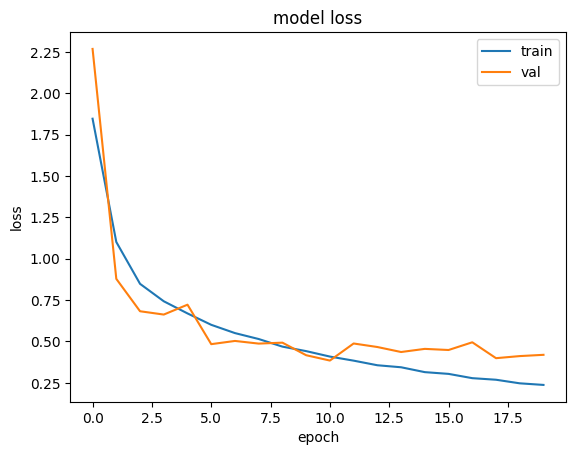

In [21]:
# Visualize the training and validation loss over epochs
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

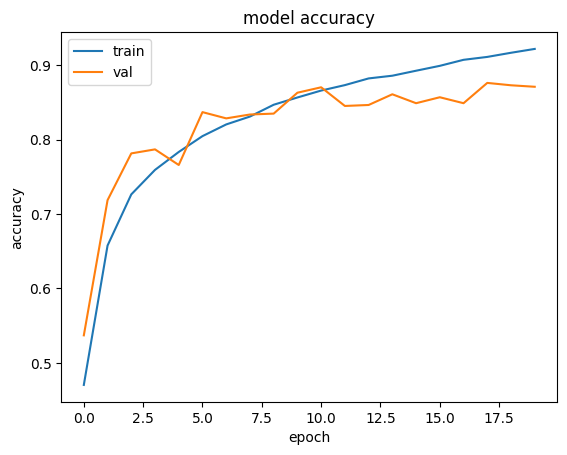

In [22]:
# Visualize the training and validation accuracy over epochs
plt.plot(model_training.history['accuracy'])
plt.plot(model_training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Evaluate the model prediction on a data sample
pred = model_vgg19_cifar10.predict(X_test[:1]) # Make prediction on a data sample
print("Model prediction: " + str(pred)) # Model prediction
print("True label: " + str(Y_test[:1])) # True label

1/1 [==============================] - 0s 29ms/step
Model prediction: [[1.3776383e-04 6.0451010e-05 6.0799993e-03 1.0276769e-02 5.5877636e-03
  7.2022555e-03 4.3381509e-04 9.7004426e-01 8.0959144e-05 9.5978568e-05]]
True label: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [24]:
# Evaluate the model prediction on the entire test set
preds = model_vgg19_cifar10.predict(X_test) # Make prediction on the entire test set
preds_index = np.argmax(preds, axis=1) # Get the index of maximum class probability of each of the data sample
label_index = np.argmax(Y_test, axis=1) # Get the index of maximum class label

313/313 [==============================] - 3s 10ms/step


In [25]:
# Compare the predictions with the true labels
comparison_result = np.equal(preds_index, label_index) # Return the comparison result which is an array of True/False.

# Calculate the number of correct predictions (True values in the comparison result array).
correct_preds = comparison_result.sum() # Compute the sum of elements across dimensions of a tensor.

# Show accuracy
print("Number of correct predictions: " + str(correct_preds))
print("Test accuracy: " + str(correct_preds/X_test.shape[0]))

Number of correct predictions: 8677
Test accuracy: 0.8677


In [26]:
# Evaluate the model accuracy using the function model.evaluate()
model_eval = model_vgg19_cifar10.evaluate(X_test, Y_test, batch_size=4096)
print("List of metrics" + str(model_vgg19_cifar10.metrics_names)) # List of possible metrics of the model evaluation, this is the metrics specified in the model.compile().

print("Test loss: " + str(model_eval[0])) # Test loss 
print("Test accuracy: " + str(model_eval[1])) # Test accuracy

3/3 [==============================] - 2s 448ms/step - loss: 0.4533 - accuracy: 0.8677
List of metrics['loss', 'accuracy']
Test loss: 0.4532740116119385
Test accuracy: 0.8676999807357788
